---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 3**: Improving Lexical Search

### 📅 **Due Date**: Day of Lecture 4, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

You'll apply what we covered in Lecture 3 (Lexical Search & BM25) to a real e-commerce search problem using the **WANDS dataset** 
- WANDS stands for Wayfair Annotated Dataset. It's a dataset of furniture products and search queries, along with human relevance judgments.

You will:
1. **Build a search engine** from scratch using BM25.
2. **Learn how to evaluate search results** using NDCG — a metric for measuring search quality
3. **Attempt to improve your search engine** by adding multiple fields
4. **Use LLMs to improve your search engine** by adding simple query understanding

Yes, *you* will do all these things. Let's go!

---

## Task 1: Environment Setup

First, let's set up your environment and verify everything works.

### 1a. Install dependencies and verify imports

Run `uv add pystemmer` in your terminal to add the Snowball stemmer. Then run the cell below to verify all imports work.

In [4]:
# Task 1a: Verify imports work
import pandas as pd
import numpy as np
from collections import Counter
import string
from pathlib import Path
# a stemmer from `pystemmer` for better tokenization
import Stemmer 
# llm packages
import litellm
from pydantic import BaseModel, Field
from typing import Optional
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Pandas display settings
# pd.set_option('display.max_colwidth', 100)

# Ignore pydantic warnings for litellm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

print("All imports successful!")

All imports successful!


### 1b. Verify API keys

Test that your API keys work by making a simple call.

In [5]:
# Task 1b: Verify API keys
response = litellm.completion(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=20
)
print(response.choices[0].message.content)

API working!


---

## Task 2: Load and Explore the WANDS Dataset

The **WANDS dataset** (Wayfair Annotated Dataset) contains:
- 43K furniture products from Wayfair
- 480 real search queries
- 233K human relevance judgments (query-product pairs)

This is a real-world search benchmark used to evaluate e-commerce search systems!

**Data Source**: [WANDS on GitHub](https://github.com/wayfair/WANDS)

The data files are pre-downloaded in the `data/` directory:
- `wayfair-products.csv` - Product catalog
- `wayfair-queries.csv` - Search queries
- `wayfair-labels.csv` - Relevance judgments

### Data Loading Functions (provided)

Run the cell below to define the loading functions.

In [6]:
# Data loading functions (provided)
# Note: Data from WANDS (Wayfair Annotated Dataset)
# Source: https://github.com/wayfair/WANDS

def load_wands_products(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS products from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-products.csv
        
    Returns:
        DataFrame with product information including product_id, product_name,
        product_class, category_hierarchy, product_description, etc.
    """
    filepath = Path(data_dir) / "wayfair-products.csv"
    products = pd.read_csv(filepath, sep='\t')
    products = products.rename(columns={'category hierarchy': 'category_hierarchy'})
    return products

def load_wands_queries(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS queries from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-queries.csv
        
    Returns:
        DataFrame with query_id and query columns
    """
    filepath = Path(data_dir) / "wayfair-queries.csv"
    queries = pd.read_csv(filepath, sep='\t')
    return queries

def load_wands_labels(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS relevance labels from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-labels.csv
        
    Returns:
        DataFrame with query_id, product_id, label (Exact/Partial/Irrelevant),
        and grade (2/1/0) columns
    """
    filepath = Path(data_dir) / "wayfair-labels.csv"
    labels = pd.read_csv(filepath, sep='\t')
    grade_map = {'Exact': 2, 'Partial': 1, 'Irrelevant': 0}
    labels['grade'] = labels['label'].map(grade_map)
    return labels

print("Loading functions defined!")

Loading functions defined!


### 2a. Load the data

Use the provided functions to load all three datasets. Print the number of rows in each.

In [7]:
# Task 2a: Load the data

# Load all three datasets
products = load_wands_products(data_dir="data")
queries = load_wands_queries(data_dir="data")
labels = load_wands_labels(data_dir="data")

# Print the number of rows in each
print(f"Products: {len(products):,} rows")
print(f"Queries: {len(queries):,} rows")
print(f"Labels: {len(labels):,} rows")

Products: 42,994 rows
Queries: 480 rows
Labels: 233,448 rows


### 2b. Explore products

List the available columns, and display a few sample products. 

Which columns might be useful for search?

In [8]:
# List available columns
print("Available columns in products DataFrame:")
print(products.columns.tolist())

Available columns in products DataFrame:
['product_id', 'product_name', 'product_class', 'category_hierarchy', 'product_description', 'product_features', 'rating_count', 'average_rating', 'review_count']


In [9]:
# Display a few sample products
products.head(3)

,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0


In [11]:
# Which columns might be useful for search?
# 
# Most useful columns for search:
# - product_name: The main searchable field - users often search by product names
# - product_description: Contains detailed text about the product
# - product_class: The category (e.g., "Coffee Tables", "Rugs") - helps match product type
# - category_hierarchy: Broader categorization that can help with filtering
#
# Less useful for text search but good for filtering:
# - product_id: Unique identifier (not for text search)
# - product_features: Could contain additional searchable attributes

print("Sample of key columns for search:")
products[['product_id', 'product_name', 'product_class', 'product_description']].head(3)

Sample of key columns for search:


,product_id,product_name,product_class,product_description
0,0,solid wood platform bed,Beds,"good , deep sleep can be quite difficult to ha..."
1,1,all-clad 7 qt . slow cooker,Slow Cookers,"create delicious slow-cooked meals , from tend..."
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,prepare home-cooked meals on any schedule with...


### 2c. Understand relevance judgments

The `labels` dataset contains human judgments of relevance. In particular, for each query-product pair, it contains:
| Label        | Grade | Description                                 |
|--------------|-------|---------------------------------------------|
| Exact        |   2   | This product is exactly what the user wants |
| Partial      |   1   | This product is somewhat relevant           |
| Irrelevant   |   0   | This product doesn't match the query        |

First, let's look at the distribution of grades.

In [12]:
# Task 2c: Understand judgments

# Look at the distribution of labels/grades
print("Distribution of relevance labels:")
print(labels['label'].value_counts())
print()
print("Distribution of grades:")
print(labels['grade'].value_counts().sort_index())

Distribution of relevance labels:
label
Partial       146633
Irrelevant     61201
Exact          25614
Name: count, dtype: int64

Distribution of grades:
grade
0     61201
1    146633
2     25614
Name: count, dtype: int64


In [13]:
# Show a sample of labels with query text
sample_labels = labels.merge(queries, on='query_id').merge(
    products[['product_id', 'product_name']], on='product_id'
).head(5)
sample_labels[['query', 'product_name', 'label', 'grade']]

,query,product_name,label,grade
0,salon chair,21.7 '' w waiting room chair with wood frame,Exact,2
1,salon chair,22.5 '' wide polyester side chair,Irrelevant,0
2,salon chair,24.4 '' w metal lounge chair with metal frame,Exact,2
3,salon chair,25 '' wide faux leather manual swivel standard...,Exact,2
4,salon chair,27.6 '' w antimicrobial leather seat waiting r...,Exact,2


---
## Task 3: Build and Run BM25 Search

Now let's build a BM25 search engine! We'll use the same concepts from Lecture 3.

### Provided Functions

We're giving you these functions to work with. Run the next cell to define them, then look at the examples.

| Function | What it does |
|----------|--------------|
| `snowball_tokenize(text)` | Tokenizes text, removes punctuation, stems words |
| `build_index(docs, tokenizer)` | Builds an inverted index from a list of documents |
| `get_tf(term, doc_id, index)` | Gets term frequency for a term in a document |
| `get_df(term, index)` | Gets document frequency for a term (how many docs contain the term) |
| `bm25_idf(df, num_docs)` | Calculates the IDF component of BM25 |
| `bm25_tf(tf, doc_len, avg_doc_len)` | Calculates the TF normalization for BM25 |
| `score_bm25(query, index, ...)` | Scores all documents for a query using BM25 |
| `search_products(query, ...)` | Searches and returns top-k results |

In [14]:
# Provided functions - run this cell to define them

stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    """
    Tokenize text with Snowball stemming.
    
    Args:
        text: The text to tokenize
        
    Returns:
        List of stemmed tokens
    """
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """
    Build an inverted index from a list of documents.
    
    Args:
        docs: List of document strings to index
        tokenizer: Function that takes text and returns list of tokens
        
    Returns:
        index: dict mapping term -> {doc_id: term_count}
        doc_lengths: list of document lengths (in tokens)
    """
    index = {}
    doc_lengths = []
    
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    
    return index, doc_lengths

def get_tf(term: str, doc_id: int, index: dict) -> int:
    """
    Get term frequency for a term in a document.
    
    Args:
        term: The term to look up
        doc_id: The document ID
        index: The inverted index
        
    Returns:
        Term frequency (count), or 0 if not found
    """
    if term in index and doc_id in index[term]:
        return index[term][doc_id]
    return 0

def get_df(term: str, index: dict) -> int:
    """
    Get document frequency for a term.
    
    Args:
        term: The term to look up
        index: The inverted index
        
    Returns:
        Number of documents containing the term
    """
    if term in index:
        return len(index[term])
    return 0

def bm25_idf(df: int, num_docs: int) -> float:
    """
    BM25 IDF formula.
    
    Args:
        df: Document frequency
        num_docs: Total number of documents
        
    Returns:
        IDF score
    """
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    """
    BM25 TF normalization.
    
    Args:
        tf: Term frequency
        doc_len: Document length in tokens
        avg_doc_len: Average document length
        k1: Saturation parameter (default 1.2)
        b: Length normalization (default 0.75)
        
    Returns:
        Normalized TF score
    """
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """
    Score all documents using BM25.
    
    Args:
        query: The search query
        index: Inverted index
        num_docs: Total number of documents
        doc_lengths: List of document lengths
        tokenizer: Tokenization function
        
    Returns:
        Array of scores for each document
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue
        
        idf = bm25_idf(df, num_docs)
        
        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    
    return scores

def search_products(query: str, products_df: pd.DataFrame, index: dict, 
                    doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    """
    Search products and return top-k results.
    
    Args:
        query: The search query
        products_df: DataFrame of products
        index: Inverted index
        doc_lengths: Document lengths
        tokenizer: Tokenization function
        k: Number of results to return
        
    Returns:
        DataFrame with top-k products and scores
    """
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

print("All functions defined!")

All functions defined!


In [ ]:
# Examples of each function

# 1. snowball_tokenize - tokenizes and stems text
print("1. snowball_tokenize('Running shoes are amazing!')")
print(f"   -> {snowball_tokenize('Running shoes are amazing!')}")
print("   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'")

# 2. build_index - builds inverted index (we'll use a tiny example)
tiny_docs = ["red shoe", "blue shoe", "red hat"]
tiny_index, tiny_lengths = build_index(tiny_docs, snowball_tokenize)
print("\n2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)")
print(f"   Index: {tiny_index}")
print(f"   Lengths: {tiny_lengths}")

# 3. get_tf - get term frequency
print("\n3. get_tf('red', doc_id=0, tiny_index)")
print(f"   -> {get_tf('red', 0, tiny_index)}  (doc 0 = 'red shoe' has 1 'red')")

# 4. get_df - get document frequency  
print("\n4. get_df('red', tiny_index)")
print(f"   -> {get_df('red', tiny_index)}  ('red' appears in 2 documents)")

# 5. bm25_idf - calculate IDF (rare terms get higher scores)
print("\n5. bm25_idf(df=100, num_docs=10000)")
print(f"   -> {bm25_idf(100, 10000):.4f}  (term in 100 of 10000 docs)")

# 6. bm25_tf - normalize term frequency by document length
print("\n6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)")
print(f"   -> {bm25_tf(3, 50, 100):.4f}  (short doc gets boosted)")

# 7-8. score_bm25 and search_products - we'll use these next!
print("\nWe'll use score_bm25() and search_products() in Task 3a!")

### 3a. Create BM25 index for product_name

Build an inverted index for the `product_name` field and run a sample search for a product.

In [15]:
# Task 3a: Create BM25 index for product_name

# Build inverted index on product names
name_index, name_lengths = build_index(products['product_name'].tolist(), snowball_tokenize)

print(f"Indexed {len(products)} products")
print(f"Vocabulary size: {len(name_index)} unique terms")
print(f"Average document length: {np.mean(name_lengths):.1f} tokens")

# Run a sample search
sample_query = "coffee table"
results = search_products(sample_query, products, name_index, name_lengths, snowball_tokenize, k=5)

print(f"\nTop 5 results for '{sample_query}':")
results[['rank', 'product_name', 'product_class', 'score']]

Indexed 42994 products
Vocabulary size: 25570 unique terms
Average document length: 6.5 tokens

Top 5 results for 'coffee table':


,rank,product_name,product_class,score
33290,1,coffee table,Coffee & Cocktail Tables,7.812564
20513,2,coffee table,Coffee & Cocktail Tables,7.812564
22679,3,coffee table,Coffee & Cocktail Tables,7.812564
608,4,coffee table,Coffee & Cocktail Tables,7.812564
5173,5,coffee table,Patio Tables,7.812564


### 3b. Add product_description to search

Create a second index for `product_description` and combine scores from both fields.

**Hint**: You can combine the two scores by adding them together. This is like multi-field search from Lecture 3.

In [16]:
# Task 3b: Add product_description to search

# Build index for product descriptions
desc_index, desc_lengths = build_index(products['product_description'].tolist(), snowball_tokenize)

print(f"Description index vocabulary size: {len(desc_index)} unique terms")
print(f"Average description length: {np.mean(desc_lengths):.1f} tokens")

# Create a multi-field search function that combines both indexes
def search_name_and_desc(query: str, k: int = 10) -> pd.DataFrame:
    """Search using both product_name and product_description fields."""
    # Get scores from both indexes
    name_scores = score_bm25(query, name_index, len(products), name_lengths, snowball_tokenize)
    desc_scores = score_bm25(query, desc_index, len(products), desc_lengths, snowball_tokenize)
    
    # Combine scores by adding them
    combined_scores = name_scores + desc_scores
    
    # Get top-k results
    top_k_idx = np.argsort(-combined_scores)[:k]
    
    results = products.iloc[top_k_idx].copy()
    results['score'] = combined_scores[top_k_idx]
    results['name_score'] = name_scores[top_k_idx]
    results['desc_score'] = desc_scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

# Test the combined search
sample_query = "wooden coffee table"
results = search_name_and_desc(sample_query, k=5)

print(f"\nTop 5 results for '{sample_query}' (name + description):")
results[['rank', 'product_name', 'score', 'name_score', 'desc_score']]

Description index vocabulary size: 20386 unique terms
Average description length: 65.4 tokens

Top 5 results for 'wooden coffee table' (name + description):


,rank,product_name,score,name_score,desc_score
5434,1,wooden coffee table,25.372065,13.865785,11.506280
9364,2,diahann wooden coffee table,24.929077,12.834006,12.095071
5371,3,forsman wooden coffee table,24.678406,12.834006,11.844400
5390,4,treadaway wooden coffee table,24.346768,12.834006,11.512763
31465,5,wellkamp wooden coffee table,23.680868,12.834006,10.846862


---

## Task 4: Measuring Search Quality

We built a little search engine. How do we know if it's any good?

Consider two search results for "coffee table":

| Ranking A | Ranking B |
|-----------|-----------|
| 1. Wooden Coffee Table (Exact) | 1. Metal Lamp (Irrelevant) |
| 2. Glass Coffee Table (Exact) | 2. Wooden Coffee Table (Exact) |
| 3. Metal Lamp (Irrelevant) | 3. Glass Coffee Table (Exact) |

### A. Precision

One way to measure the quality of a ranking is to look at the precision within these first 3 results. 
- Precision is the ratio of relevant results to total results at position k.
- We call this precision@3, and more generally precision@k is the ratio of relevant results to total results at position k.
  
In this scenario, if we consider "exact" results as relevant, then both rankings have precision@3 = 2/3.

### B. DCG

Both rankings have the same precision, but Ranking A is clearly better 
- users look at results from the top down, and most people never scroll past the first few results
- as such, rankings that return relevant results earlier are better

So we need a metric that rewards **relevant** results, and rewards them **more** when they appear at the **top**

NDCG (Normalized Discounted Cumulative Gain) does this by giving each result a "gain" based on its relevance, then **discounting** that gain based on position.

**The formula** for each result at position $i$:

$$\text{gain}_i = \frac{2^{\text{relevance}} - 1}{\log_2(i + 1)}$$

- **Numerator** $(2^{\text{relevance}} - 1)$: How relevant is this result?
  - Irrelevant (0): $2^0 - 1 = 0$ (no gain)
  - Partial (1): $2^1 - 1 = 1$ (some gain)
  - Exact (2): $2^2 - 1 = 3$ (lots of gain!)
  
- **Denominator** $\log_2(i + 1)$: The "discount" based on position
  - Position 1: $\log_2(2) = 1$ (no discount)
  - Position 2: $\log_2(3) = 1.58$ (small discount)
  - Position 10: $\log_2(11) = 3.46$ (bigger discount)

**DCG** sums the discounted score for each result

$$\text{DCG} = \sum_{i=1}^{k} \frac{2^{\text{relevance}_i} - 1}{\log_2(i + 1)}$$

### 3. NDCG: Normalized DCG

One problem with DCG is that the score depends on how many relevant products exist. 
- A query with 10 exact matches will have a higher DCG than one with only 2, even if both rankings are "perfect."

One solution is to normalize by the *ideal* DCG — what the score would be if we ranked everything perfectly (all relevant results at the top).

$$\text{NDCG} = \frac{\text{DCG}}{\text{Ideal DCG}}$$

- **NDCG = 1.0**: Perfect -- best possible order
- **NDCG = 0.5**: OK -- some good some bad
- **NDCG = 0.0**: Worst -- results are irrelevant

**Read the above carefully.** In the next cell, explain in your own words: why does the discount formula use $\log_2$? What happens to results at position 1 vs position 10?

In [17]:
# Task 4a: Answer in a comment
# Why does DCG use log2 for the discount? What's the effect on position 1 vs position 10?
#
# The log2 function is used because it provides a smooth, gradually increasing discount
# that models how users actually behave when scanning search results:
#
# 1. Users pay the most attention to the first result (position 1: log2(2) = 1, no discount)
# 2. Attention drops off quickly at first, then more slowly for later positions
# 3. log2 creates diminishing returns - the difference between position 1 and 2 is larger
#    than the difference between position 9 and 10
#
# Effect on position 1 vs position 10:
# - Position 1:  discount = log2(1+1) = log2(2) = 1.0   → full credit (no discount)
# - Position 10: discount = log2(10+1) = log2(11) ≈ 3.46 → gain divided by 3.46
#
# This means a relevant result at position 1 contributes ~3.5x more to the score
# than the same result at position 10, reflecting user attention patterns.

print("Position discounts:")
for i in [1, 2, 3, 5, 10]:
    discount = np.log2(i + 1)
    print(f"  Position {i}: log2({i+1}) = {discount:.2f} → gain divided by {discount:.2f}")

Position discounts:
  Position 1: log2(2) = 1.00 → gain divided by 1.00
  Position 2: log2(3) = 1.58 → gain divided by 1.58
  Position 3: log2(4) = 2.00 → gain divided by 2.00
  Position 5: log2(6) = 2.58 → gain divided by 2.58
  Position 10: log2(11) = 3.46 → gain divided by 3.46


### 4b. Calculate NDCG by hand

Let's work through an example step by step.

**Scenario**: You search for "wooden coffee table" and get these results:

| Position | Product | Relevance |
|----------|---------|----------|
| 1 | Glass Coffee Table | Partial (1) |
| 2 | Wooden Coffee Table | Exact (2) |
| 3 | Wooden Side Table | Partial (1) |
| 4 | Metal Coffee Table | Irrelevant (0) |
| 5 | Wooden Coffee Table (different) | Exact (2) |

**Your task**: Calculate DCG and NDCG@5 by hand.

In [18]:
# Task 4b: Calculate NDCG by hand
# 
# Given relevances: [1, 2, 1, 0, 2] (Partial, Exact, Partial, Irrelevant, Exact)
#
# Step 1: Calculate DCG
# DCG = sum of (2^relevance - 1) / log2(position + 1)
#
# Position 1: (2^1 - 1) / log2(2) = 1 / 1.0    = 1.0000
# Position 2: (2^2 - 1) / log2(3) = 3 / 1.585  = 1.8928
# Position 3: (2^1 - 1) / log2(4) = 1 / 2.0    = 0.5000
# Position 4: (2^0 - 1) / log2(5) = 0 / 2.322  = 0.0000
# Position 5: (2^2 - 1) / log2(6) = 3 / 2.585  = 1.1610
#
# DCG = 1.0 + 1.8928 + 0.5 + 0.0 + 1.1610 = 4.5538

print("DCG Calculation:")
relevances = [1, 2, 1, 0, 2]
dcg_sum = 0
for i, rel in enumerate(relevances):
    pos = i + 1
    gain = (2**rel - 1) / np.log2(pos + 1)
    dcg_sum += gain
    print(f"  Position {pos}: (2^{rel} - 1) / log2({pos+1}) = {2**rel - 1} / {np.log2(pos+1):.3f} = {gain:.4f}")
print(f"\nDCG@5 = {dcg_sum:.4f}")

# Step 2: Calculate Ideal DCG (best possible ordering)
# Ideal order: [2, 2, 1, 1, 0] (sorted by relevance descending)
#
# Position 1: (2^2 - 1) / log2(2) = 3 / 1.0    = 3.0000
# Position 2: (2^2 - 1) / log2(3) = 3 / 1.585  = 1.8928
# Position 3: (2^1 - 1) / log2(4) = 1 / 2.0    = 0.5000
# Position 4: (2^1 - 1) / log2(5) = 1 / 2.322  = 0.4307
# Position 5: (2^0 - 1) / log2(6) = 0 / 2.585  = 0.0000
#
# Ideal DCG = 3.0 + 1.8928 + 0.5 + 0.4307 + 0.0 = 5.8235

print("\nIdeal DCG Calculation (sorted relevances: [2, 2, 1, 1, 0]):")
ideal_relevances = sorted(relevances, reverse=True)
ideal_dcg = 0
for i, rel in enumerate(ideal_relevances):
    pos = i + 1
    gain = (2**rel - 1) / np.log2(pos + 1)
    ideal_dcg += gain
    print(f"  Position {pos}: (2^{rel} - 1) / log2({pos+1}) = {2**rel - 1} / {np.log2(pos+1):.3f} = {gain:.4f}")
print(f"\nIdeal DCG@5 = {ideal_dcg:.4f}")

# Step 3: Calculate NDCG
# NDCG = DCG / Ideal DCG = 4.5538 / 5.8235 = 0.7819
ndcg = dcg_sum / ideal_dcg
print(f"\nNDCG@5 = DCG / Ideal DCG = {dcg_sum:.4f} / {ideal_dcg:.4f} = {ndcg:.4f}")

DCG Calculation:
  Position 1: (2^1 - 1) / log2(2) = 1 / 1.000 = 1.0000
  Position 2: (2^2 - 1) / log2(3) = 3 / 1.585 = 1.8928
  Position 3: (2^1 - 1) / log2(4) = 1 / 2.000 = 0.5000
  Position 4: (2^0 - 1) / log2(5) = 0 / 2.322 = 0.0000
  Position 5: (2^2 - 1) / log2(6) = 3 / 2.585 = 1.1606

DCG@5 = 4.5533

Ideal DCG Calculation (sorted relevances: [2, 2, 1, 1, 0]):
  Position 1: (2^2 - 1) / log2(2) = 3 / 1.000 = 3.0000
  Position 2: (2^2 - 1) / log2(3) = 3 / 1.585 = 1.8928
  Position 3: (2^1 - 1) / log2(4) = 1 / 2.000 = 0.5000
  Position 4: (2^1 - 1) / log2(5) = 1 / 2.322 = 0.4307
  Position 5: (2^0 - 1) / log2(6) = 0 / 2.585 = 0.0000

Ideal DCG@5 = 5.8235

NDCG@5 = DCG / Ideal DCG = 4.5533 / 5.8235 = 0.7819


### 4c. Implement NDCG function

Now implement the NDCG calculation in code. Verify your implementation matches your hand calculation!

In [19]:
# Task 4c: Implement NDCG function

def calculate_dcg(relevances: list[int], k: int = 10) -> float:
    """
    Calculate Discounted Cumulative Gain at position k.
    
    Args:
        relevances: List of relevance scores in rank order
        k: Number of results to consider
        
    Returns:
        DCG@k score
    """
    dcg = 0.0
    for i, rel in enumerate(relevances[:k]):
        # Position is 1-indexed
        position = i + 1
        # DCG formula: (2^relevance - 1) / log2(position + 1)
        dcg += (2**rel - 1) / np.log2(position + 1)
    return dcg

def calculate_ndcg(relevances: list[int], k: int = 10) -> float:
    """
    Calculate Normalized Discounted Cumulative Gain at position k.
    
    Args:
        relevances: List of relevance scores in rank order
        k: Number of results to consider
        
    Returns:
        NDCG@k score (between 0 and 1)
    """
    # Calculate actual DCG
    dcg = calculate_dcg(relevances, k)
    
    # Calculate ideal DCG (best possible ordering)
    ideal_relevances = sorted(relevances, reverse=True)
    ideal_dcg = calculate_dcg(ideal_relevances, k)
    
    # Avoid division by zero
    if ideal_dcg == 0:
        return 0.0
    
    return dcg / ideal_dcg

print("NDCG functions defined!")

NDCG functions defined!


In [20]:
# Verify your implementation matches your hand calculation
test_relevances = [1, 2, 1, 0, 2]

dcg = calculate_dcg(test_relevances, k=5)
ndcg = calculate_ndcg(test_relevances, k=5)

print(f"DCG@5 = {dcg:.4f}")
print(f"NDCG@5 = {ndcg:.4f}")

# These should match your hand calculations from Task 4b!

DCG@5 = 4.5533
NDCG@5 = 0.7819


---

## Task 5: Evaluate Your Search Strategy

Now let's evaluate our BM25 search across all queries in the WANDS dataset.

### Evaluation Helper Functions (provided)

In [21]:
# Evaluation helper functions (provided)

def get_relevance_grades(product_ids: list[int], query_id: int, labels_df: pd.DataFrame) -> list[int]:
    """
    Get relevance grades for a list of product IDs given a query.
    
    Args:
        product_ids: List of product IDs in rank order
        query_id: The query ID
        labels_df: DataFrame with relevance labels
        
    Returns:
        List of relevance grades (0, 1, or 2) for each product
    """
    # Get labels for this query
    query_labels = labels_df[labels_df['query_id'] == query_id]
    label_dict = dict(zip(query_labels['product_id'], query_labels['grade']))
    
    # Look up grades for each product (default to 0 if not labeled)
    return [label_dict.get(pid, 0) for pid in product_ids]

def evaluate_single_query(query_text: str, query_id: int, products_df: pd.DataFrame,
                          labels_df: pd.DataFrame, search_func, k: int = 10) -> float:
    """
    Evaluate search for a single query.
    
    Args:
        query_text: The search query text
        query_id: The query ID for looking up labels
        products_df: DataFrame of products
        labels_df: DataFrame with relevance labels
        search_func: Function that takes query and returns DataFrame with product_id column
        k: Number of results to consider
        
    Returns:
        NDCG@k score for this query
    """
    results = search_func(query_text)
    product_ids = results['product_id'].tolist()[:k]
    relevances = get_relevance_grades(product_ids, query_id, labels_df)
    return calculate_ndcg(relevances, k)

def evaluate_search(search_func, products_df: pd.DataFrame, queries_df: pd.DataFrame,
                    labels_df: pd.DataFrame, k: int = 10, verbose: bool = True) -> pd.DataFrame:
    """
    Evaluate search across all queries.
    
    Args:
        search_func: Function that takes query string and returns DataFrame with product_id
        products_df: DataFrame of products
        queries_df: DataFrame of queries
        labels_df: DataFrame with relevance labels
        k: Number of results to consider
        verbose: Whether to print progress
        
    Returns:
        DataFrame with query_id, query, and ndcg columns
    """
    results = []
    
    for _, row in queries_df.iterrows():
        query_id = row['query_id']
        query_text = row['query']
        
        ndcg = evaluate_single_query(query_text, query_id, products_df, 
                                     labels_df, search_func, k)
        results.append({
            'query_id': query_id,
            'query': query_text,
            'ndcg': ndcg
        })
    
    results_df = pd.DataFrame(results)
    
    if verbose:
        print(f"Evaluated {len(results_df)} queries")
        print(f"Mean NDCG@{k}: {results_df['ndcg'].mean():.4f}")
    
    return results_df

print("Evaluation functions defined!")

Evaluation functions defined!


### 5a. Run evaluation on all queries

Create a search function and evaluate it on all queries.

In [22]:
# Task 5a: Run evaluation on all queries

# Create a search function that uses our name+description index
def baseline_search(query: str) -> pd.DataFrame:
    """Baseline search using product_name + product_description."""
    return search_name_and_desc(query, k=10)

# Evaluate on all queries
baseline_results = evaluate_search(
    search_func=baseline_search,
    products_df=products,
    queries_df=queries,
    labels_df=labels,
    k=10,
    verbose=True
)

# Show some statistics
print(f"\nStatistics:")
print(f"  Min NDCG:    {baseline_results['ndcg'].min():.4f}")
print(f"  Max NDCG:    {baseline_results['ndcg'].max():.4f}")
print(f"  Median NDCG: {baseline_results['ndcg'].median():.4f}")

Evaluated 480 queries
Mean NDCG@10: 0.8682

Statistics:
  Min NDCG:    0.0000
  Max NDCG:    1.0000
  Median NDCG: 0.9795


### 5b. Identify failing queries

Find queries where our search performed poorly (NDCG = 0 or very low). Analyze one of them.

In [23]:
# Task 5b: Identify failing queries

# Find queries with NDCG = 0 or very low
failing_queries = baseline_results[baseline_results['ndcg'] == 0]
low_ndcg_queries = baseline_results[baseline_results['ndcg'] < 0.1]

print(f"Queries with NDCG = 0: {len(failing_queries)}")
print(f"Queries with NDCG < 0.1: {len(low_ndcg_queries)}")

print("\nSample failing queries:")
print(failing_queries[['query', 'ndcg']].head(10))

# Analyze one failing query in detail
if len(failing_queries) > 0:
    bad_query = failing_queries.iloc[0]['query']
    bad_query_id = failing_queries.iloc[0]['query_id']
    
    print(f"\n--- Analyzing query: '{bad_query}' ---")
    
    # What does our search return?
    search_results = baseline_search(bad_query)
    print(f"\nOur search returns:")
    print(search_results[['rank', 'product_name', 'product_class', 'score']].head(5))
    
    # What are the actual relevant products?
    relevant = labels[(labels['query_id'] == bad_query_id) & (labels['grade'] > 0)]
    relevant_with_names = relevant.merge(products[['product_id', 'product_name', 'product_class']], on='product_id')
    print(f"\nActual relevant products ({len(relevant)} total):")
    print(relevant_with_names[['product_name', 'product_class', 'label']].head(5))

Queries with NDCG = 0: 18
Queries with NDCG < 0.1: 18

Sample failing queries:
                              query  ndcg
147                    drum picture   0.0
173                   star wars rug   0.0
178        promo codes or discounts   0.0
204  dull bed with shirt head board   0.0
218         small loving roomtables   0.0
240       pull out sleeper loveseat   0.0
299                        merlyn 6   0.0
339               ottoman bed queen   0.0
343                   one alium way   0.0
360                   drudge report   0.0

--- Analyzing query: 'drum picture' ---

Our search returns:
       rank                    product_name   product_class      score
15321     1  lavada 4-light drum chandelier     Chandeliers  14.677446
13904     2  jurgens mahogany picture frame  Picture Frames  13.923356
29189     3          satrogan picture frame  Picture Frames  13.800654
27494     4     gemmill matte picture frame  Picture Frames  13.604143
39625     5            design picture fram

### 5c. Analyze the distribution

Visualize the distribution of NDCG scores.

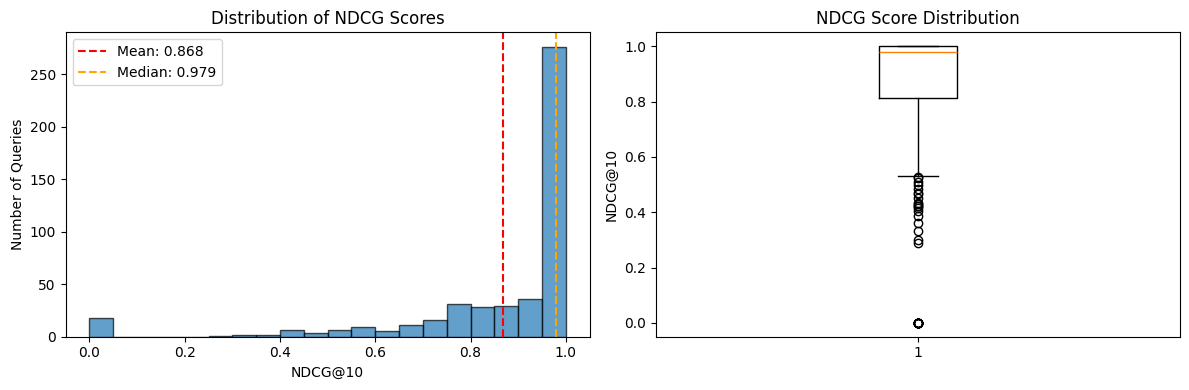


NDCG Percentiles:
  10th percentile: 0.6067
  25th percentile: 0.8124
  50th percentile: 0.9795
  75th percentile: 1.0000
  90th percentile: 1.0000


In [25]:
# Task 5c: Analyze the distribution

import matplotlib.pyplot as plt

# Create histogram of NDCG scores
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(baseline_results['ndcg'], bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(baseline_results['ndcg'].mean(), color='red', linestyle='--', label=f"Mean: {baseline_results['ndcg'].mean():.3f}")
axes[0].axvline(baseline_results['ndcg'].median(), color='orange', linestyle='--', label=f"Median: {baseline_results['ndcg'].median():.3f}")
axes[0].set_xlabel('NDCG@10')
axes[0].set_ylabel('Number of Queries')
axes[0].set_title('Distribution of NDCG Scores')
axes[0].legend()

# Box plot
axes[1].boxplot(baseline_results['ndcg'], vert=True)
axes[1].set_ylabel('NDCG@10')
axes[1].set_title('NDCG Score Distribution')

plt.tight_layout()
plt.show()

# Print percentile breakdown
print("\nNDCG Percentiles:")
for p in [10, 25, 50, 75, 90]:
    print(f"  {p}th percentile: {baseline_results['ndcg'].quantile(p/100):.4f}")

---

## Task 6: Improve Search with Additional Fields

Our baseline only searches the `product_name` field. Let's improve by adding more fields!

### 6a. Index product_class field

The `product_class` field contains the category of the product (e.g., "Rugs", "Coffee Tables"). This is a powerful signal!

Create a search function that combines all three fields (name, description, class).

In [26]:
# Task 6a: Index product_class field

# Build index for product_class
class_index, class_lengths = build_index(products['product_class'].tolist(), snowball_tokenize)

print(f"Product class index vocabulary size: {len(class_index)} unique terms")
print(f"Average class length: {np.mean(class_lengths):.1f} tokens")

# Create a three-field search function
def search_three_fields(query: str, k: int = 10) -> pd.DataFrame:
    """Search using product_name, product_description, and product_class fields."""
    # Get scores from all three indexes
    name_scores = score_bm25(query, name_index, len(products), name_lengths, snowball_tokenize)
    desc_scores = score_bm25(query, desc_index, len(products), desc_lengths, snowball_tokenize)
    class_scores = score_bm25(query, class_index, len(products), class_lengths, snowball_tokenize)
    
    # Combine scores by adding them (can also use weights)
    combined_scores = name_scores + desc_scores + class_scores
    
    # Get top-k results
    top_k_idx = np.argsort(-combined_scores)[:k]
    
    results = products.iloc[top_k_idx].copy()
    results['score'] = combined_scores[top_k_idx]
    results['name_score'] = name_scores[top_k_idx]
    results['desc_score'] = desc_scores[top_k_idx]
    results['class_score'] = class_scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

# Test the three-field search
sample_query = "coffee table"
results = search_three_fields(sample_query, k=5)
print(f"\nTop 5 results for '{sample_query}' (three-field search):")
results[['rank', 'product_name', 'product_class', 'score', 'class_score']]

Product class index vocabulary size: 628 unique terms
Average class length: 2.2 tokens

Top 5 results for 'coffee table' (three-field search):


,rank,product_name,product_class,score,class_score
34496,1,picacho coffee table,Coffee & Cocktail Tables,21.260129,5.174661
29952,2,metpally coffee table,Coffee & Cocktail Tables,20.946081,5.174661
26857,3,elmcrest coffee table,Coffee & Cocktail Tables,20.834425,5.174661
16877,4,mendivil coffee table,Coffee & Cocktail Tables,20.817171,5.174661
38673,5,abdulsamet coffee table,Coffee & Cocktail Tables,20.817171,5.174661


### 6b. Evaluate three-field search

Now evaluate your three-field search on all queries to see how it compares to the baseline.

In [27]:
# Task 6b: Evaluate three-field search

# Create wrapper for evaluation
def three_field_search_wrapper(query: str) -> pd.DataFrame:
    return search_three_fields(query, k=10)

# Evaluate on all queries
three_field_results = evaluate_search(
    search_func=three_field_search_wrapper,
    products_df=products,
    queries_df=queries,
    labels_df=labels,
    k=10,
    verbose=True
)

# Compare to baseline
print(f"\nComparison:")
print(f"  Baseline (name+desc) Mean NDCG@10: {baseline_results['ndcg'].mean():.4f}")
print(f"  Three-field Mean NDCG@10:          {three_field_results['ndcg'].mean():.4f}")
print(f"  Improvement: {(three_field_results['ndcg'].mean() - baseline_results['ndcg'].mean()):.4f}")

Evaluated 480 queries
Mean NDCG@10: 0.8791

Comparison:
  Baseline (name+desc) Mean NDCG@10: 0.8682
  Three-field Mean NDCG@10:          0.8791
  Improvement: 0.0109


### 6c. Compare to baseline

Analyze which queries improved and which degraded when using three-field search.

In [28]:
# Task 6c: Compare to baseline

# Merge results to compare
comparison = baseline_results.merge(
    three_field_results[['query_id', 'ndcg']], 
    on='query_id', 
    suffixes=('_baseline', '_three_field')
)
comparison['improvement'] = comparison['ndcg_three_field'] - comparison['ndcg_baseline']

# Queries that improved
improved = comparison[comparison['improvement'] > 0.01]
print(f"Queries that improved (>0.01): {len(improved)}")
print("\nTop improved queries:")
print(improved.nlargest(5, 'improvement')[['query', 'ndcg_baseline', 'ndcg_three_field', 'improvement']])

# Queries that degraded
degraded = comparison[comparison['improvement'] < -0.01]
print(f"\nQueries that degraded (<-0.01): {len(degraded)}")
if len(degraded) > 0:
    print("\nMost degraded queries:")
    print(degraded.nsmallest(5, 'improvement')[['query', 'ndcg_baseline', 'ndcg_three_field', 'improvement']])

# Queries that were zero and are still zero
still_zero = comparison[(comparison['ndcg_baseline'] == 0) & (comparison['ndcg_three_field'] == 0)]
print(f"\nQueries still at NDCG=0: {len(still_zero)}")
if len(still_zero) > 0:
    print(still_zero['query'].tolist()[:5])

Queries that improved (>0.01): 112

Top improved queries:
                         query  ndcg_baseline  ndcg_three_field  improvement
339          ottoman bed queen       0.000000          0.693426     0.693426
447                 carpet 5x6       0.386853          0.955024     0.568171
240  pull out sleeper loveseat       0.000000          0.505128     0.505128
403                 teal chair       0.000000          0.471628     0.471628
84    full metal bed rose gold       0.554827          0.996349     0.441522

Queries that degraded (<-0.01): 70

Most degraded queries:
                       query  ndcg_baseline  ndcg_three_field  improvement
304      moen 5995 arbor one       0.921787          0.289065    -0.632722
45    70s inspired furniture       0.583342          0.000000    -0.583342
42    toddler couch fold out       0.919721          0.468451    -0.451270
13      outdoor privacy wall       0.927414          0.500000    -0.427414
134  black hanging bookshelf       1.000000  

---

## Task 7: Query Understanding with LLM

Sometimes users search for "star wars rug" when they really want a "rug with Star Wars theme". An LLM can help us understand what the user is actually looking for!

### 7a. Extract product type from query

Write a function using LiteLLM with structured outputs (Pydantic) to extract key information from a query.

In [31]:
# Task 7a: Extract product type, theme, material, color, and any other information from the query
import json

# Define a Pydantic model for structured output
class QueryUnderstanding(BaseModel):
    """Structured extraction of query attributes for search enhancement."""
    product_type: Optional[str] = Field(
        default=None, 
        description="The main product category (e.g., 'rug', 'table', 'sofa', 'chair', 'lamp')"
    )
    theme: Optional[str] = Field(
        default=None, 
        description="Any theme or style mentioned (e.g., 'star wars', 'modern', 'rustic', 'vintage')"
    )
    material: Optional[str] = Field(
        default=None, 
        description="Material mentioned (e.g., 'wooden', 'metal', 'leather', 'glass')"
    )
    color: Optional[str] = Field(
        default=None, 
        description="Color mentioned (e.g., 'blue', 'red', 'black', 'white')"
    )
    style: Optional[str] = Field(
        default=None, 
        description="Design style (e.g., 'modern', 'traditional', 'industrial', 'farmhouse')"
    )

def extract_query_attributes(query: str) -> QueryUnderstanding:
    """
    Use an LLM to extract structured attributes from a search query.
    
    Args:
        query: The user's search query
        
    Returns:
        QueryUnderstanding object with extracted attributes
    """
    response = litellm.completion(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": """You are a helpful assistant that extracts product attributes from furniture search queries.
Extract the product type, theme, material, color, and style if present. Be concise.
Return a JSON object with these fields: product_type, theme, material, color, style.
Use null for any field not mentioned in the query."""
            },
            {
                "role": "user",
                "content": f"Extract attributes from this furniture search query: '{query}'"
            }
        ],
        response_format={"type": "json_object"},
        max_tokens=200
    )
    
    # Parse the JSON response
    content = response.choices[0].message.content
    data = json.loads(content)
    
    return QueryUnderstanding(
        product_type=data.get("product_type"),
        theme=data.get("theme"),
        material=data.get("material"),
        color=data.get("color"),
        style=data.get("style")
    )

print("Query understanding function defined!")

Query understanding function defined!


In [32]:
# Test your query understanding function by running it against these test queries
test_queries = [
    "star wars rug",
    "wooden coffee table",
    "blue leather sofa",
    "modern metal bookshelf"
]

for q in test_queries:
    result = extract_query_attributes(q)
    print(f"\nQuery: '{q}'")
    print(f"  Product type: {result.product_type}")
    print(f"  Theme: {result.theme}")
    print(f"  Material: {result.material}")
    print(f"  Color: {result.color}")
    print(f"  Style: {result.style}")


Query: 'star wars rug'
  Product type: rug
  Theme: star wars
  Material: None
  Color: None
  Style: None

Query: 'wooden coffee table'
  Product type: coffee table
  Theme: None
  Material: wood
  Color: None
  Style: None

Query: 'blue leather sofa'
  Product type: sofa
  Theme: None
  Material: leather
  Color: blue
  Style: None

Query: 'modern metal bookshelf'
  Product type: bookshelf
  Theme: modern
  Material: metal
  Color: None
  Style: None


### 7b. Create an LLM-enhanced search

Use the extracted product type to boost matching results. If the LLM identifies "rug" as the product type, boost products where `product_class` contains "rug".

In [ ]:
# Task 7b: Create an LLM-enhanced search

def llm_enhanced_search(query: str, k: int = 10, boost_factor: float = 2.0) -> pd.DataFrame:
    """
    Search using LLM query understanding to boost relevant product classes.
    
    Args:
        query: The user's search query
        k: Number of results to return
        boost_factor: How much to boost matching product classes
        
    Returns:
        DataFrame with search results
    """
    # Get base scores from three-field search
    name_scores = score_bm25(query, name_index, len(products), name_lengths, snowball_tokenize)
    desc_scores = score_bm25(query, desc_index, len(products), desc_lengths, snowball_tokenize)
    class_scores = score_bm25(query, class_index, len(products), class_lengths, snowball_tokenize)
    
    # Combine base scores
    combined_scores = name_scores + desc_scores + class_scores
    
    # Use LLM to understand the query
    try:
        query_attrs = extract_query_attributes(query)
        
        # Boost products matching the identified product type
        if query_attrs.product_type:
            product_type_lower = query_attrs.product_type.lower()
            # Create a mask for products with matching class
            class_match = products['product_class'].fillna('').str.lower().str.contains(product_type_lower)
            combined_scores = np.where(class_match, combined_scores * boost_factor, combined_scores)
        
        # Also boost by color if mentioned
        if query_attrs.color:
            color_lower = query_attrs.color.lower()
            # Check if color appears in name or description
            color_match = (
                products['product_name'].fillna('').str.lower().str.contains(color_lower) |
                products['product_description'].fillna('').str.lower().str.contains(color_lower)
            )
            combined_scores = np.where(color_match, combined_scores * 1.5, combined_scores)
            
    except Exception as e:
        print(f"LLM extraction failed for '{query}': {e}")
    
    # Get top-k results
    top_k_idx = np.argsort(-combined_scores)[:k]
    
    results = products.iloc[top_k_idx].copy()
    results['score'] = combined_scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

print("LLM-enhanced search function defined!")

In [ ]:
# Test LLM-enhanced search on a failing query
test_query = "star wars rug"
print(f"Testing LLM-enhanced search for: '{test_query}'")

# First, show what the baseline returns
print("\n--- Baseline (three-field) results ---")
baseline = search_three_fields(test_query, k=5)
print(baseline[['rank', 'product_name', 'product_class', 'score']])

# Now show LLM-enhanced results
print("\n--- LLM-enhanced results ---")
enhanced = llm_enhanced_search(test_query, k=5)
print(enhanced[['rank', 'product_name', 'product_class', 'score']])

# Check against ground truth
query_id = queries[queries['query'] == test_query]['query_id'].values[0]
relevant = labels[(labels['query_id'] == query_id) & (labels['grade'] > 0)]
relevant_with_names = relevant.merge(products[['product_id', 'product_name', 'product_class']], on='product_id')
print(f"\n--- Actual relevant products ({len(relevant)} total) ---")
print(relevant_with_names[['product_name', 'product_class', 'label']].head(5))

---
## Task 8: Submit via Pull Request

Now let's submit your work using the Git workflow from previous homeworks.
- [ ] Create a new branch called `homework-3`
- [ ] Commit you work and push it to the branch
- [ ] Create a PR with a nice description of your changes
- [ ] Merge the PR to your main branch
  
**The TA will verify your submission by checking the merged PR on your GitHub repo.**

**Also remember to submit your homework on Blackboard!**
